In [1]:
from typing import *
from analysis.core.currency import Currency
from analysis.core.utils import load_data_from_currencies, compute_log_returns
from analysis.core.time_utils import Bounds
from datetime import date, timedelta


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Current portfolio that we have
existing_portfolio: Dict[Currency, float] = {
    Currency.BTC: 0.6086,
    Currency.ETH: 0.105,
    Currency.XRP: 0.049,
    Currency.SOL: 0.0278,
    Currency.TRX: 0.0066,
    Currency.TON: 0.003,
    Currency.LINK: 0.0535,
    Currency.AAVE: 0.0175,
    Currency.ONDO: 0.0171,
    Currency.ENA: 0.0061,
    Currency.MOVE: 0.0057,
    Currency.HYPE: 0.0232,
    Currency.UNI: 0.0162,
    Currency.TAO: 0.0082,
    Currency.MKR: 0.0024,
    Currency.USDT: 0.0167 * 3
}

<h4>Check portfolios of different BTC/ETH combinations similar to VanEck report</h4>

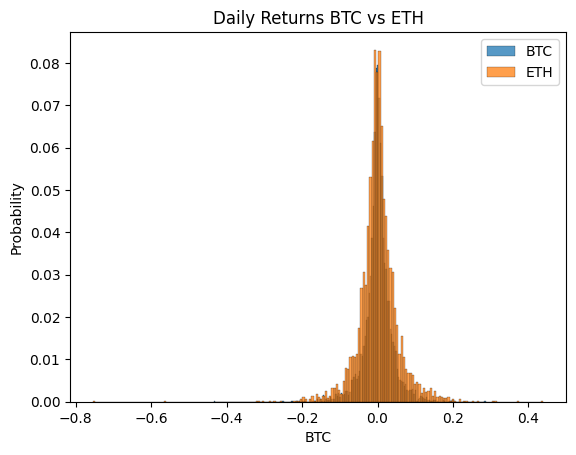

In [2]:
start_date: date = date(2013, 1, 1)
end_date: date = date(2025, 2, 28)
bounds: Bounds = Bounds.for_days(start_date, end_date)
selected_currencies: List[Currency] = [Currency.BTC, Currency.ETH]

df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=selected_currencies)
df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)

plt.title("Daily Returns BTC vs ETH")
sns.histplot(df_returns["BTC"], label="BTC", stat="probability")
sns.histplot(df_returns["ETH"], label="ETH", stat="probability")

plt.legend()
plt.show()

<h4>BTC and ETH 60%, 40% allocations</h4>

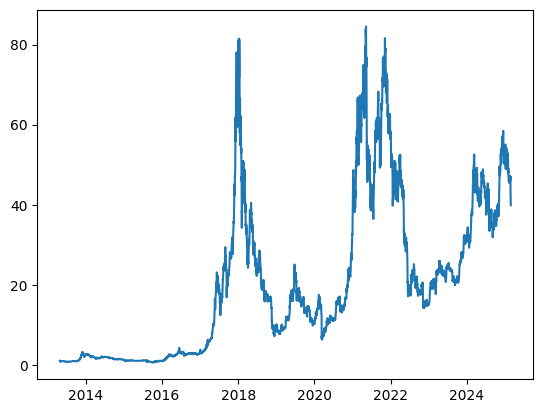

In [3]:
def compute_return_series_for_portfolio(df_returns: pd.DataFrame, portfolio: Dict[Currency, float]) -> pd.Series:
    currencies: List[str] = [currency.name for currency in portfolio]
    weights: np.ndarray = np.array(portfolio.values())

    return (df_returns[currencies] * weights).sum(axis=1)


portfolio_6040: Dict[Currency, float] = {
    Currency.BTC: 0.6, Currency.ETH: 0.4
}

returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=portfolio_6040)

plt.plot((1 + returns).cumprod())
plt.show()

<h4>Other allocations of BTC/ETH</h4>

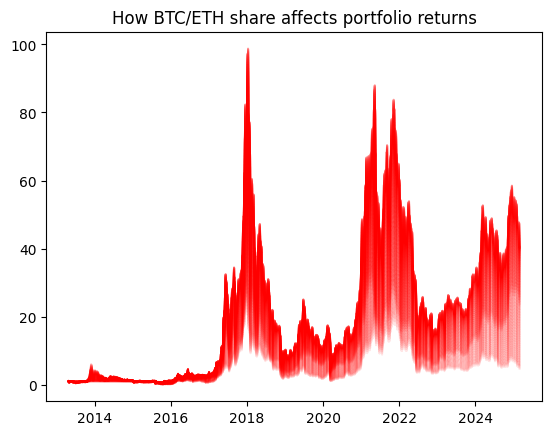

In [4]:
shares: np.ndarray = np.arange(0, 1.01, 0.01)
final_pnl: List[float] = []

for btc_share in np.arange(0, 1.01, 0.01):
    returns: pd.Series = compute_return_series_for_portfolio(
        df_returns=df_returns, 
        portfolio={Currency.BTC: btc_share, Currency.ETH: 1-btc_share}
    )
    final_pnl.append((1 + returns).prod())
    
    plt.plot((1 + returns).cumprod(), color="red", alpha=.1)

plt.title("How BTC/ETH share affects portfolio returns")
plt.show()

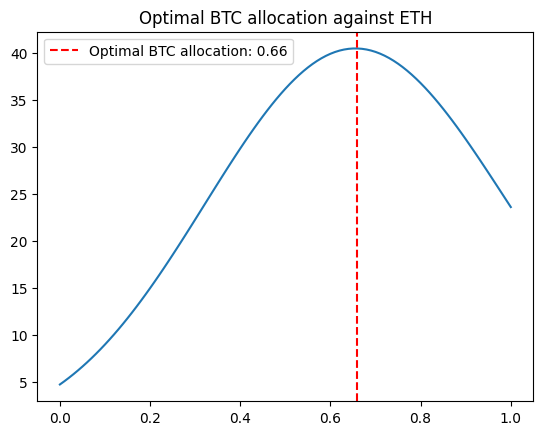

In [5]:
final_pnl = np.array(final_pnl)
optimal_btc_share: float = shares[final_pnl.argmax()]

plt.title("Optimal BTC allocation against ETH")
plt.plot(shares, final_pnl)
plt.axvline(optimal_btc_share, color="red", linestyle="--", label=f"Optimal BTC allocation: {optimal_btc_share}")
plt.legend()
plt.show()

<h4>If we take volatility of returns into account. Max Sharpe portfolio from BTC & ETH</h4>

In [6]:
# compute max sharpe portfolio
from analysis.portfolio_makers.max_sharpe import MaxSharpePortfolio


optimizer: MaxSharpePortfolio = MaxSharpePortfolio()
optimal_btc_eth_portfolio: Dict[Currency, float] = optimizer.find_portfolio(
    df_returns=df_returns, selected_currencies=[Currency.BTC, Currency.ETH]
)

optimal_btc_eth_portfolio

{<Currency.BTC: 2>: np.float64(0.6050926742340681),
 <Currency.ETH: 4>: np.float64(0.3949073257659318)}

Получаем похожую картинку, что кстати совпадает с нашим существующим портфелем

<h4>Compute historical stats of existing portfolio</h4>

Так как данных нет для всех активов, мы будем держать кэш до момента, когда появятся торги актива

In [7]:
today: date = date.today()
start_date: date = today - timedelta(days=180)

bounds: Bounds = Bounds.for_days(start_date, today)
df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=list(existing_portfolio.keys()))
df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
df_returns[Currency.USDT.name] = 0

# fill missing returns with zeroes
df_returns = df_returns.fillna(0)

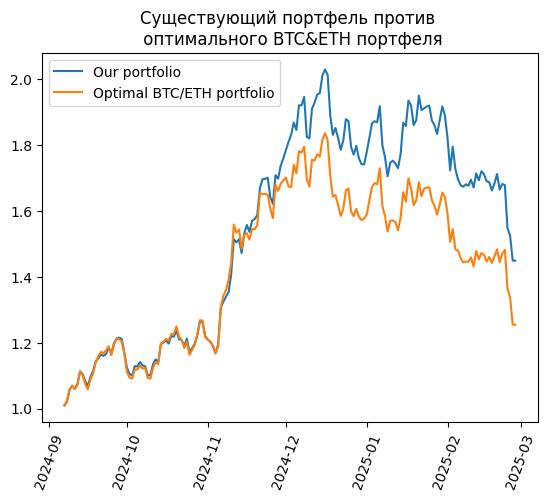

In [8]:
portfolio_returns: pd.Series = compute_return_series_for_portfolio(
    df_returns=df_returns, portfolio=existing_portfolio
)
optimal_btceth_returns: pd.Series = compute_return_series_for_portfolio(
    df_returns=df_returns, portfolio=optimal_btc_eth_portfolio
)

plt.title("Существующий портфель против \n оптимального BTC&ETH портфеля")
plt.plot((portfolio_returns + 1).cumprod(), label="Our portfolio")
plt.plot((optimal_btceth_returns + 1).cumprod(), label="Optimal BTC/ETH portfolio")
plt.legend()
plt.xticks(rotation=70)
plt.show()

In [9]:
from tqdm import tqdm


def compute_multiple_returns(offsets: List[timedelta]) -> pd.DataFrame:
    today: date = date.today()

    returns: List[Dict[str, float]] = []

    for offset in tqdm(offsets):
        bounds: Bounds = Bounds.for_days(today - offset, today)
        df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=list(existing_portfolio.keys()))
        df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
        df_returns[Currency.USDT.name] = 0
        # fill missing returns with zeroes
        df_returns = df_returns.fillna(0)

        # Compute returns of BTC/ETH portfolio and existing portfolio
        existing_portfolio_returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=existing_portfolio)
        optimal_btceth_returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=optimal_btc_eth_portfolio)

        optimal_btceth_return: float = (optimal_btceth_returns + 1).prod()
        existing_portfolio_return: float = (existing_portfolio_returns + 1).prod()

        returns.append({
            "past": offset.days,
            "btceth_portfolio": optimal_btceth_return,
            "btceth_portfolio_annualized_return": (1 + optimal_btceth_returns.mean()) ** 365 - 1,
            "btceth_portfolio_annualized_vol": optimal_btceth_returns.std() * np.sqrt(365),
            "existing_portfolio": existing_portfolio_return,
            "existing_portfolio_annualized_return": (1 + existing_portfolio_returns.mean())**365 - 1,
            "existing_portfolio_annualized_vol": existing_portfolio_returns.std() * np.sqrt(365),
        })

    return pd.DataFrame(returns)

In [10]:
offsets: List[timedelta] = [
    timedelta(days=30),
    timedelta(days=90),
    timedelta(days=180),
    timedelta(days=365),
    timedelta(days=365*3),
    timedelta(days=365*5)
]

df_stats = compute_multiple_returns(offsets=offsets)

100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


In [11]:
df_stats["btceth_sharpe_ratio"] = df_stats["btceth_portfolio_annualized_return"] / df_stats["btceth_portfolio_annualized_vol"]
df_stats["existing_portfolio_sharpe_ratio"] = df_stats["existing_portfolio_annualized_return"] / df_stats["existing_portfolio_annualized_vol"]

<h4>Overall return</h4>

In [12]:
df_stats[["past", "btceth_portfolio", "existing_portfolio"]]

,past,btceth_portfolio,existing_portfolio
0,30,0.812543,0.807342
1,90,0.732010,0.785231
2,180,1.254735,1.448940
3,365,0.858965,1.082463
4,1095,0.964356,1.265738
5,1825,2.652364,2.956723


<h4>Annualized Sharpe ratios</h4>

In [13]:
df_stats[["past", "btceth_sharpe_ratio", "existing_portfolio_sharpe_ratio"]]

,past,btceth_sharpe_ratio,existing_portfolio_sharpe_ratio
0,30,-1.971075,-2.196009
1,90,-1.415216,-1.204857
2,180,1.649572,3.017828
3,365,-0.017621,0.454724
4,1095,0.280345,0.455436
5,1825,0.818375,0.830125


<h4>Annualized returns</h4>

In [14]:
df_stats[["past", "btceth_portfolio_annualized_return", "existing_portfolio_annualized_return"]]

,past,btceth_portfolio_annualized_return,existing_portfolio_annualized_return
0,30,-0.952212,-0.957580
1,90,-0.707698,-0.603450
2,180,0.818115,1.435008
3,365,-0.009520,0.227004
4,1095,0.156782,0.228026
5,1825,0.564470,0.495915


<h4>Annualized volatility</h4>

In [15]:
df_stats[["past", "btceth_portfolio_annualized_vol", "existing_portfolio_annualized_vol"]]

,past,btceth_portfolio_annualized_vol,existing_portfolio_annualized_vol
0,30,0.483093,0.436055
1,90,0.500064,0.500848
2,180,0.495956,0.475510
3,365,0.540265,0.499214
4,1095,0.559246,0.500678
5,1825,0.689745,0.597398


<h4>Если мы делаем ребаланс, то есть строим совершенно новые портфели каждый месяц, используя данные за последние 3 месяца</h4>

In [16]:
def compute_return_series_of_actively_rebalanced_portfolio(
    bounds: Bounds, interval: timedelta, step: timedelta, use_currencies: List[Currency]
) -> pd.Series:
    df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=use_currencies)
    df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
    
    df_returns[Currency.USDT.name] = 0
    # fill missing returns with zeroes
    df_returns = df_returns.fillna(0)
    
    overlapping_bounds: List[Bounds] = bounds.generate_overlapping_bounds(step=step, interval=interval)
    
    returns_tss: List[pd.Series] = []
    
    for sub_bounds in tqdm(overlapping_bounds):
        portfolio: Dict[Currency, float] = optimizer.find_portfolio(
            df_returns=df_returns.loc[sub_bounds.day0: sub_bounds.day1], selected_currencies=list(Currency)
        )
        returns = compute_return_series_for_portfolio(
            df_returns=df_returns.loc[sub_bounds.day1: sub_bounds.day1 + timedelta(days=30)],
            portfolio=portfolio
        )
        returns_tss.append(returns)

    return pd.concat(returns_tss)

In [17]:
bounds: Bounds = Bounds.for_days(
    start_date=date.today() - timedelta(days=270), end_date=date.today()
)

actively_rebalanced_portfolio_returns: pd.Series = compute_return_series_of_actively_rebalanced_portfolio(
    bounds=bounds, interval=timedelta(days=90), step=timedelta(days=30), use_currencies=list(Currency)
)

100%|██████████| 8/8 [00:00<00:00, 199.92it/s]


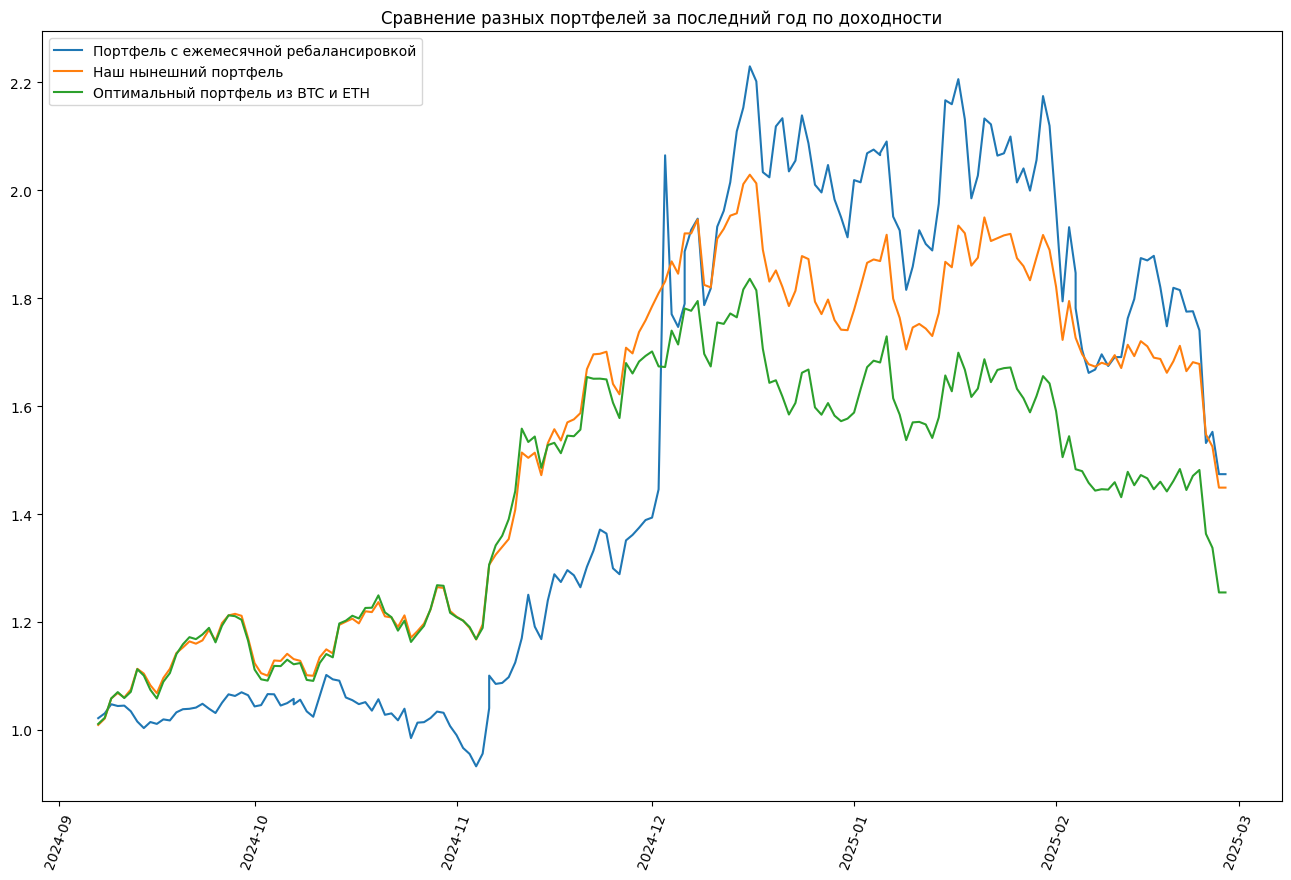

In [18]:
plt.figure(figsize=(16, 10))

plt.title("Сравнение разных портфелей за последний год по доходности")
plt.plot((1 + actively_rebalanced_portfolio_returns).cumprod(), label="Портфель с ежемесячной ребалансировкой")
plt.plot((portfolio_returns + 1).cumprod(), label="Наш нынешний портфель")
plt.plot((optimal_btceth_returns + 1).cumprod(), label="Оптимальный портфель из BTC и ETH")

plt.legend()
plt.xticks(rotation=70)
plt.savefig("three_strategies_compared.png")
plt.show()

In [19]:
stats: List[Dict[str, Any]] = []

for offset in offsets:
    bounds: Bounds = Bounds.for_days(
        start_date=date.today() - offset, end_date=date.today()
    )
    actively_rebalanced_portfolio_returns: pd.Series = compute_return_series_of_actively_rebalanced_portfolio(
        bounds=bounds, interval=timedelta(days=90), step=timedelta(days=30), use_currencies=list(Currency)
    )
    stats.append({
        "past": offset.days,
        "portfolio_rebalanced_90/30": (actively_rebalanced_portfolio_returns + 1).prod(),
        "portfolio_rebalanced_90/30_annualized_return": (1 + actively_rebalanced_portfolio_returns.mean()) ** 365 - 1,
        "portfolio_rebalanced_90/30_annualized_std": actively_rebalanced_portfolio_returns.std() * np.sqrt(365)
    })

100%|██████████| 59/59 [00:01<00:00, 56.34it/s]


In [20]:
df_rebalanced = pd.DataFrame(stats)
df_rebalanced["sharpe_ratio"] = (
    df_rebalanced["portfolio_rebalanced_90/30_annualized_return"] / df_rebalanced["portfolio_rebalanced_90/30_annualized_std"]
)

df_rebalanced

,past,portfolio_rebalanced_90/30,portfolio_rebalanced_90/30_annualized_return,portfolio_rebalanced_90/30_annualized_std,sharpe_ratio
0,30,1.000000,NaN,NaN,NaN
1,90,1.000000,NaN,NaN,NaN
2,180,0.823567,-0.420005,0.746157,-0.562891
3,365,1.082198,0.335896,0.608997,0.551556
4,1095,1.943990,0.460633,0.535448,0.860276
5,1825,3.790184,0.729773,0.737007,0.990185


<h4>All Sharpe ratios</h4>

In [21]:
df_all = pd.concat([df_stats, df_rebalanced], axis=1)
df_all[["past", "btceth_sharpe_ratio", "existing_portfolio_sharpe_ratio", "sharpe_ratio"]].iloc[:, 1:]

,past,btceth_sharpe_ratio,existing_portfolio_sharpe_ratio,sharpe_ratio
0,30,-1.971075,-2.196009,NaN
1,90,-1.415216,-1.204857,NaN
2,180,1.649572,3.017828,-0.562891
3,365,-0.017621,0.454724,0.551556
4,1095,0.280345,0.455436,0.860276
5,1825,0.818375,0.830125,0.990185


<h4>All Annualized returns</h4>

In [22]:
df_all[
    ["past", "btceth_portfolio_annualized_return", "existing_portfolio_annualized_return", "portfolio_rebalanced_90/30_annualized_return"]
].iloc[:, 1:]

,past,btceth_portfolio_annualized_return,existing_portfolio_annualized_return,portfolio_rebalanced_90/30_annualized_return
0,30,-0.952212,-0.957580,NaN
1,90,-0.707698,-0.603450,NaN
2,180,0.818115,1.435008,-0.420005
3,365,-0.009520,0.227004,0.335896
4,1095,0.156782,0.228026,0.460633
5,1825,0.564470,0.495915,0.729773


<h4>All total returns</h4>

In [23]:
df_all[
    ["past", "btceth_portfolio", "existing_portfolio", "portfolio_rebalanced_90/30"]
].iloc[:, 1:]

,past,btceth_portfolio,existing_portfolio,portfolio_rebalanced_90/30
0,30,0.812543,0.807342,1.000000
1,90,0.732010,0.785231,1.000000
2,180,1.254735,1.448940,0.823567
3,365,0.858965,1.082463,1.082198
4,1095,0.964356,1.265738,1.943990
5,1825,2.652364,2.956723,3.790184


<h4>Get crypto market cap</h4>

In [24]:
import requests


resp = requests.get(
    "https://api.coinmarketcap.com/data-api/v4/global-metrics/quotes/historical?range=ALL&convertId=2781&module=marketcap"
)

C:\Users\mihai\AppData\Local\Temp\ipykernel_15708\1610413027.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_mcap["timestamp"] = pd.to_datetime(df_mcap["timestamp"], unit="s")


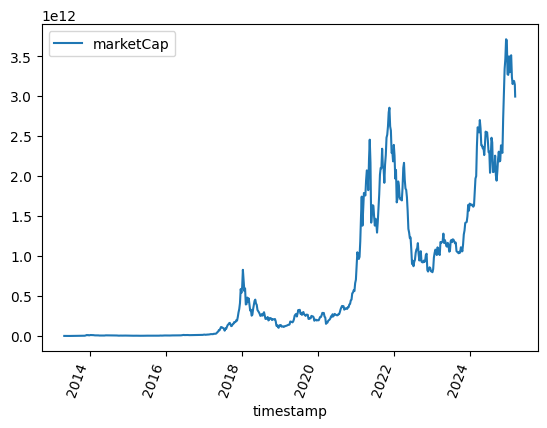

In [25]:
df_mcap: pd.DataFrame = pd.DataFrame(resp.json()["data"]["points"])
df_mcap["timestamp"] = pd.to_datetime(df_mcap["timestamp"], unit="s")
df_mcap.plot(x="timestamp", y="marketCap")

plt.xticks(rotation=70)
plt.show()

<Axes: xlabel='market_return', ylabel='Probability'>

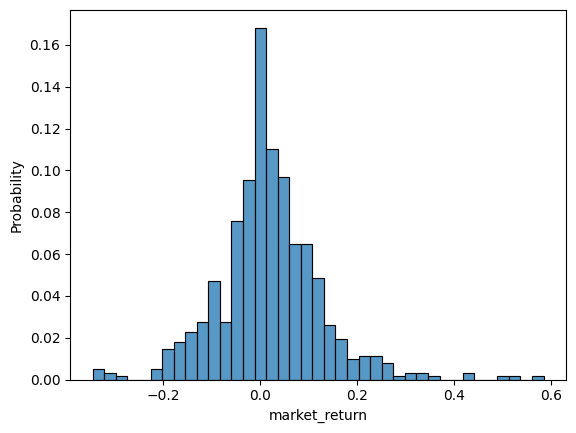

In [26]:
df_mcap["market_return"] = (df_mcap["marketCap"].shift(-1) - df_mcap["marketCap"]) / df_mcap["marketCap"]

sns.histplot(
    df_mcap["market_return"], stat="probability"
)

In [27]:
beta_values: List[Dict[str, float]] = []

for offset in tqdm(offsets):
    bounds: Bounds = Bounds.for_days(start_date=date.today() - offset, end_date=date.today())
    
    df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=list(existing_portfolio.keys()))
    df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
    df_returns[Currency.USDT.name] = 0
    # fill missing returns with zeroes
    df_returns = df_returns.fillna(0)

    # Compute returns of BTC/ETH portfolio and existing portfolio
    existing_portfolio_returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=existing_portfolio)
    existing_portfolio_returns = existing_portfolio_returns.resample("1W").apply(lambda x: (1 + x).prod() - 1)
    
    optimal_btceth_returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=optimal_btc_eth_portfolio)
    optimal_btceth_returns = optimal_btceth_returns.resample("1W").apply(lambda x: (1 + x).prod() - 1)

    df_mcap_sub = df_mcap[df_mcap["timestamp"].dt.date.between(bounds.day0, bounds.day1)].copy()
    df_mcap_sub = df_mcap_sub.dropna().reset_index(drop=True)

    min_size: int = min(df_mcap_sub.shape[0], len(optimal_btceth_returns))

    cov_btceth: float = np.cov(
        df_mcap_sub["market_return"].iloc[:min_size], optimal_btceth_returns.iloc[:min_size]
    )[0, 1]
    cov_existing_portfolio: float = np.cov(
        df_mcap_sub["market_return"].iloc[:min_size], existing_portfolio_returns.iloc[:min_size]
    )[0, 1]
    
    var_market: float = df_mcap_sub["market_return"].std()**2
    
    beta_values.append({
        "days": offset.days,
        "beta_btceth_portfolio": cov_btceth / var_market,
        "beta_existing_portfolio": cov_existing_portfolio / var_market
    })

100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


In [28]:
pd.DataFrame(beta_values)

,days,beta_btceth_portfolio,beta_existing_portfolio
0,30,1.897221,1.642876
1,90,-0.162971,-0.231970
2,180,0.277169,0.243207
3,365,0.130505,0.119673
4,1095,1.109217,1.008932
5,1825,0.178392,0.144449


In [29]:
beta_values: List[Dict[str, float]] = []

for offset in tqdm(offsets):
    bounds: Bounds = Bounds.for_days(start_date=date.today() - offset, end_date=date.today())
    
    df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=list(existing_portfolio.keys()))
    df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
    df_returns[Currency.USDT.name] = 0
    # fill missing returns with zeroes
    df_returns = df_returns.fillna(0)

    # Compute returns of BTC/ETH portfolio and existing portfolio
    existing_portfolio_returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=existing_portfolio)
    optimal_btceth_returns: pd.Series = compute_return_series_for_portfolio(df_returns=df_returns, portfolio=optimal_btc_eth_portfolio)

    cov_btceth: float = np.cov(optimal_btceth_returns, df_returns["BTC"])[0, 1]
    cov_existing_portfolio: float = np.cov(existing_portfolio_returns, df_returns["BTC"])[0, 1]
    
    var_btc: float = df_returns["BTC"].std()**2
    
    beta_values.append({
        "days": offset.days,
        "beta_btceth_portfolio": cov_btceth / var_btc,
        "beta_existing_portfolio": cov_existing_portfolio / var_btc
    })

100%|██████████| 6/6 [00:02<00:00,  2.33it/s]


<h4>Simulate paths of prices taking into account that they are correlated</h4>

In [30]:
bounds: Bounds = Bounds.for_days(
    start_date=date.today() - timedelta(days=365 * 5), end_date=date.today()
)

df_prices: pd.DataFrame = load_data_from_currencies(bounds=bounds, currencies=list(Currency))

df_returns: pd.DataFrame = compute_log_returns(df_prices=df_prices)
df_returns[Currency.USDT.name] = 0

In [31]:
mus = df_returns.mean().values
cov = df_returns.cov().values
stddevs = df_returns.std().values

<h4>Simulated return paths for the current portfolio</h4>

In [32]:
from analysis.backtest.monte_carlo import generate_correlated_gbm, get_portfolio_returns_paths

corr_matrix: np.ndarray = df_returns.corr().values # we need correlation matrix
S0: np.ndarray = np.array(df_prices.iloc[-1, :].tolist() + [1])

St: np.ndarray = generate_correlated_gbm(
    S0=S0, 
    currencies=list(existing_portfolio.keys()), 
    num_steps=365, 
    corr_matrix=corr_matrix,
    stddevs=df_returns.std().values,
    num_paths=1000
)

100%|██████████| 1000/1000 [00:00<00:00, 3397.68it/s]


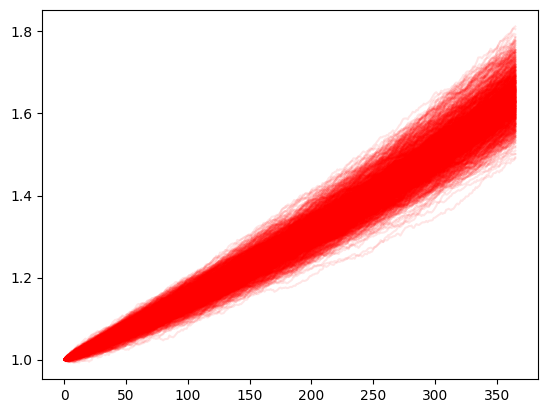

In [33]:
sim_current_portfolio: np.ndarray = get_portfolio_returns_paths(
    St=St, weights=np.array(list(existing_portfolio.values()))
)

plt.plot(sim_current_portfolio, color="red", alpha=.1)
plt.show()

<h4>Simulated return paths for BTC/ETH portfolio</h4>

In [34]:
selected_currencies: List[Currency] = [Currency.BTC, Currency.ETH]
cols = [currency.name for currency in selected_currencies]

corr_matrix: np.ndarray = df_returns[cols].corr().values # we need correlation matrix
S0 = df_prices[cols].iloc[-1].values

St: np.ndarray = generate_correlated_gbm(
    S0=S0, 
    currencies=selected_currencies, 
    num_steps=365, 
    corr_matrix=corr_matrix,
    stddevs=df_returns[cols].std().values,
    num_paths=1000
)

100%|██████████| 1000/1000 [00:00<00:00, 13331.12it/s]


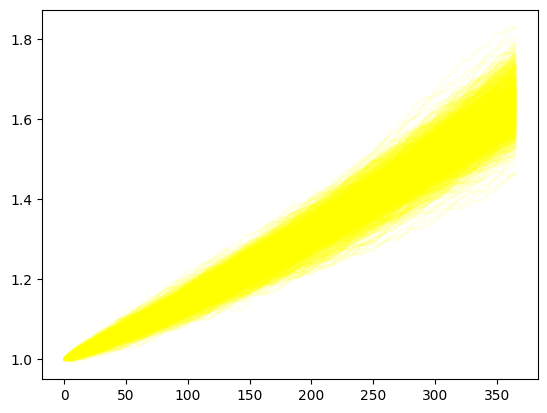

In [35]:
sim_btc_eth_portfolio: np.ndarray = get_portfolio_returns_paths(
    St=St, weights=[0.61, 0.39]
)

plt.plot(sim_btc_eth_portfolio, color="yellow", alpha=.1)
plt.show()

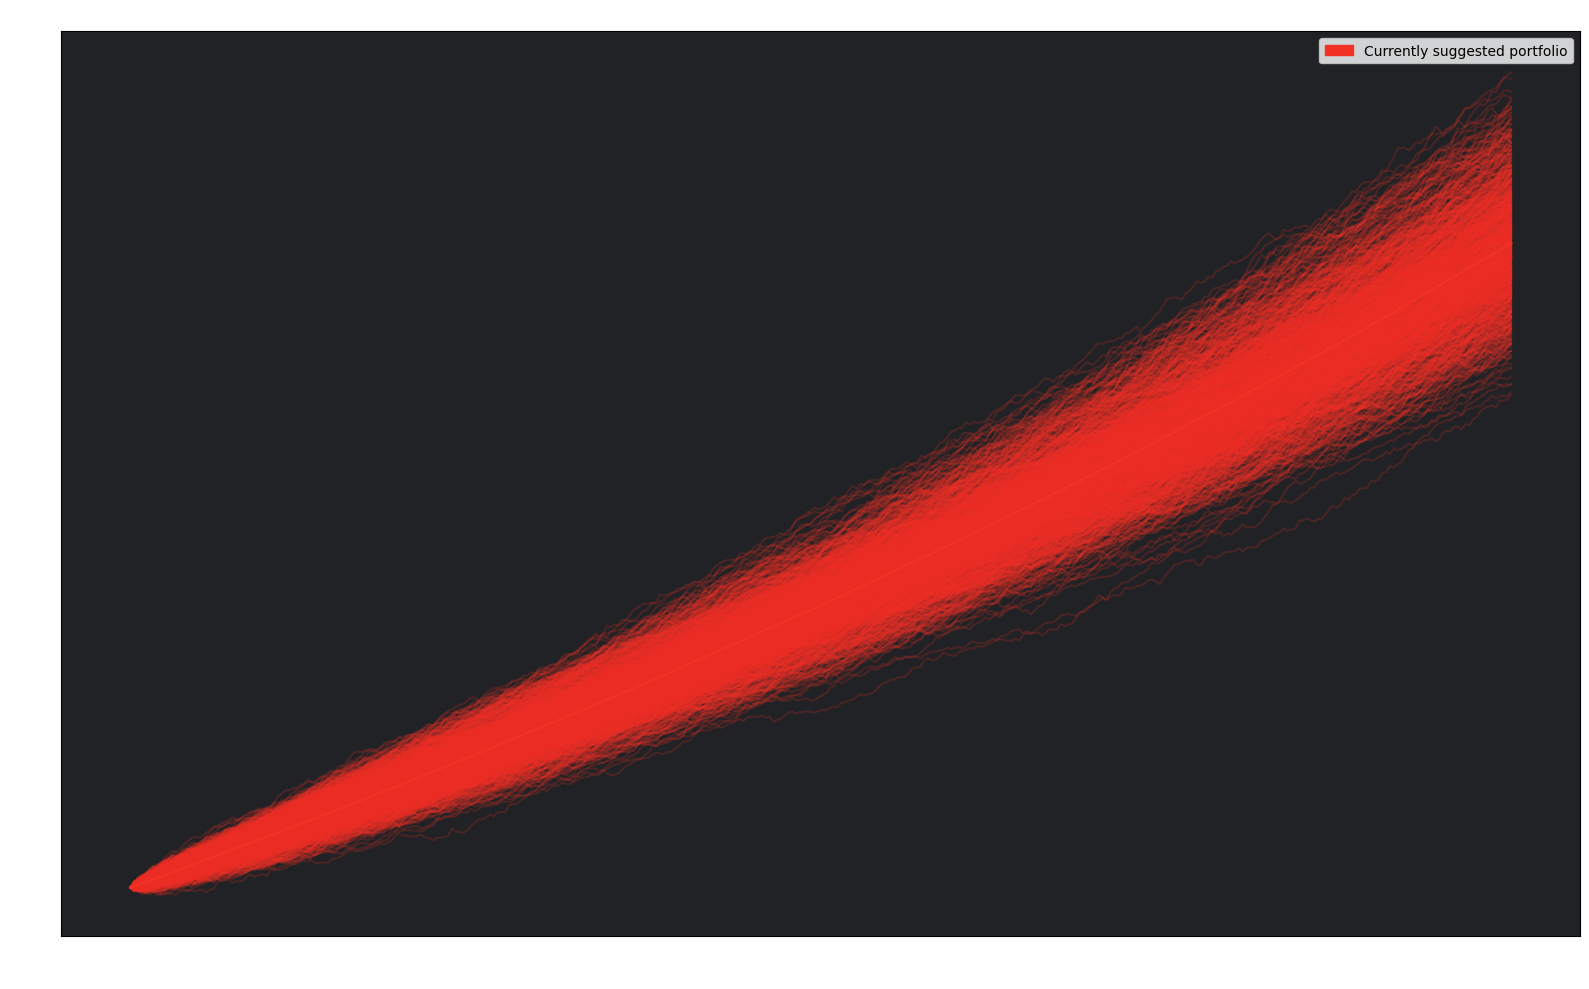

In [36]:
import matplotlib.patches as mpatches

plt.figure(figsize=(16, 10))

# Устанавливаем цвет фона
plt.gca().set_facecolor('#202226')

# Графики с прозрачными линиями
plt.plot(sim_current_portfolio, color="#F03124", alpha=.2)

# Легенда
legend_patches = [
    mpatches.Patch(color='#F03124', label="Currently suggested portfolio"),
]

# Средние значения
plt.plot(sim_current_portfolio.mean(axis=1), label="Currently suggested portfolio: Mean return path", color="#F03124", linewidth=2)

# Заголовок и легенда
plt.title("Simulated returns of portfolios for 1 year ahead", color="white")  # Устанавливаем цвет текста заголовка
plt.legend(handles=legend_patches)

# Устанавливаем цвет текста на осях и меток
plt.xlabel("Time", color="white")
plt.ylabel("Returns", color="white")
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.tight_layout()
plt.savefig("generated_paths.png")
plt.show()

In [37]:
df_sim: pd.DataFrame = pd.DataFrame({
    "terminal_mean": [sim_current_portfolio[-1, :].mean()],
    "terminal_std": [sim_current_portfolio[-1, :].std()],
    "max_drawdown": [sim_current_portfolio.min()],
    "max_return": [sim_current_portfolio.max()],
    "sharpe_ratio": [
        (sim_current_portfolio[-1, :].mean()-1) / sim_current_portfolio[-1, :].std(),
    ]
})

df_sim.index = [
    "Currently suggested portfolio",
]

df_sim

,terminal_mean,terminal_std,max_drawdown,max_return,sharpe_ratio
Currently suggested portfolio,1.641816,0.053233,0.993095,1.811945,12.056651


In [38]:
df_minmax = pd.DataFrame({
    "min_return": [sim_current_portfolio[-1, :].min(), sim_btc_eth_portfolio[-1, :].min()],
    "max_return": [sim_current_portfolio[-1, :].max(), sim_btc_eth_portfolio[-1, :].max()],
})

df_minmax.index = ["Currently suggested portfolio", "Optimal BTC/ETH portfolio"]
df_minmax

,min_return,max_return
Currently suggested portfolio,1.490742,1.811945
Optimal BTC/ETH portfolio,1.460206,1.831140
